# Section 2 — Task 3: Classification & Association Rules

# 1. Imports

In [1]:
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# mlxtend for Apriori (pip install mlxtend if import fails)
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 2. Paths

In [2]:
OUT_DIR = os.getcwd()
X_PATH = os.path.join(OUT_DIR, "iris_X_scaled.csv")
Y_PATH = os.path.join(OUT_DIR, "iris_y.csv")
print("Outputs will be saved to:", OUT_DIR)

Outputs will be saved to: /Users/williamgathii/Documents/University/Kyra/DSA-2040_Practical_Exam_Kyra_619/data_mining


# 3. Load Iris

In [3]:
X = pd.read_csv(X_PATH)
y = pd.read_csv(Y_PATH)["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X.shape, y.shape


((150, 4), (150,))

# 4. Decision Tree

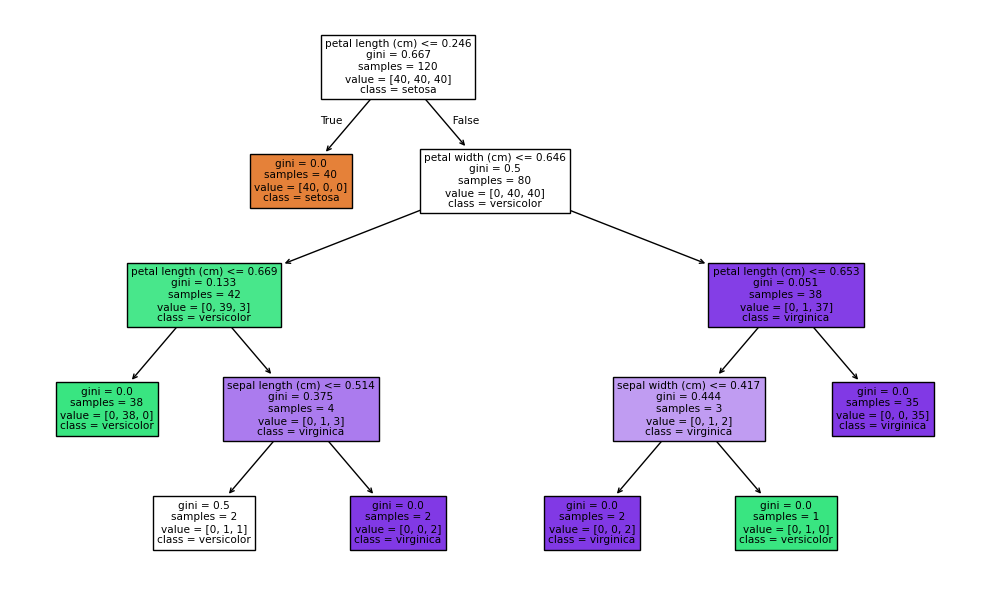

'/Users/williamgathii/Documents/University/Kyra/DSA-2040_Practical_Exam_Kyra_619/data_mining/decision_tree.png'

In [4]:
dt = DecisionTreeClassifier(random_state=42, max_depth=4)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# metrics
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_dt, average="macro", zero_division=0)
acc = accuracy_score(y_test, y_pred_dt)
dt_metrics = {"model":"DecisionTree","accuracy":acc,"precision":p,"recall":r,"f1":f1}
pd.DataFrame([dt_metrics]).round(4)

# visualize tree
plt.figure(figsize=(10,6))
plot_tree(dt, feature_names=list(X.columns), class_names=["setosa","versicolor","virginica"], filled=True)
tree_path = os.path.join(OUT_DIR, "decision_tree.png")
plt.tight_layout(); plt.savefig(tree_path, dpi=150); plt.show()
tree_path


# 5. Train KNN (k=5) & compare

In [5]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_knn, average="macro", zero_division=0)
acc = accuracy_score(y_test, y_pred_knn)
knn_metrics = {"model":"KNN(k=5)","accuracy":acc,"precision":p,"recall":r,"f1":f1}

results = pd.DataFrame([dt_metrics, knn_metrics]).round(4)
results_path = os.path.join(OUT_DIR, "classification_metrics.csv")
results.to_csv(results_path, index=False)
results


,model,accuracy,precision,recall,f1
0,DecisionTree,0.9333,0.9333,0.9333,0.9333
1,KNN(k=5),0.9667,0.9697,0.9667,0.9666


# 6. Classification Summary

In [6]:
best = results.sort_values("f1", ascending=False).iloc[0]
summary = (
    f"Best model: {best['model']} (F1={best['f1']:.3f}, Acc={best['accuracy']:.3f}, "
    f"Prec={best['precision']:.3f}, Rec={best['recall']:.3f}). "
    "Decision Tree is interpretable (see decision_tree.png) and highlights key thresholds; "
    "KNN captures local structure but depends on k and scaled distances. "
    "Metrics may vary slightly with different random splits."
)
with open(os.path.join(OUT_DIR, "classification_summary.md"), "w") as f:
    f.write(summary)
summary


'Best model: KNN(k=5) (F1=0.967, Acc=0.967, Prec=0.970, Rec=0.967). Decision Tree is interpretable (see decision_tree.png) and highlights key thresholds; KNN captures local structure but depends on k and scaled distances. Metrics may vary slightly with different random splits.'

# 7. Generate synthetic market baskets

In [7]:
random.seed(42); np.random.seed(42)

ITEMS = ["milk","bread","butter","cheese","eggs","yogurt","cereal","juice","coffee","tea",
         "beer","diapers","wipes","chips","salsa","apples","bananas","chicken","rice","pasta"]

def generate_transactions(n_tx=40):
    tx = []
    for _ in range(n_tx):
        basket = set(random.sample(ITEMS, k=random.randint(3,8)))
        # inject some realistic co-occurrences
        if "bread" in basket and random.random()<0.6: basket.add("butter")
        if "milk" in basket  and random.random()<0.6: basket.add("cereal")
        if "diapers" in basket and random.random()<0.4: basket.add("beer")
        tx.append(sorted(basket))
    return tx

transactions = generate_transactions(n_tx=40)

# save as CSV (one row per basket, comma-separated)
tx_csv = os.path.join(OUT_DIR, "transactions.csv")
pd.Series([",".join(t) for t in transactions], name="basket").to_csv(tx_csv, index=False)
len(transactions), transactions[:3], tx_csv


(40,
 [['bananas',
   'beer',
   'bread',
   'butter',
   'cheese',
   'coffee',
   'diapers',
   'juice',
   'milk'],
  ['bread', 'butter', 'cereal', 'coffee', 'juice', 'milk'],
  ['chicken', 'chips', 'coffee', 'juice', 'milk', 'rice', 'salsa', 'wipes']],
 '/Users/williamgathii/Documents/University/Kyra/DSA-2040_Practical_Exam_Kyra_619/data_mining/transactions.csv')

# 8. Apriori rules (min_support=0.2, min_confidence=0.5)

In [8]:
# one-hot encode
te = TransactionEncoder()
onehot = te.fit(transactions).transform(transactions)
df_tx = pd.DataFrame(onehot, columns=te.columns_)

# apriori + rules
freq = apriori(df_tx, min_support=0.2, use_colnames=True)
rules = association_rules(freq, metric="confidence", min_threshold=0.5)
rules = rules.sort_values("lift", ascending=False)

top5 = rules.head(5).reset_index(drop=True)
rules_path = os.path.join(OUT_DIR, "basket_rules.csv")
top5.to_csv(rules_path, index=False)
top5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(coffee),(salsa),0.400,0.250,0.20,0.500000,2.000000,1.0,0.1000,1.50,0.833333,0.444444,0.333333,0.650000
1,(salsa),(coffee),0.250,0.400,0.20,0.800000,2.000000,1.0,0.1000,3.00,0.666667,0.444444,0.666667,0.650000
2,(bread),(butter),0.275,0.500,0.25,0.909091,1.818182,1.0,0.1125,5.50,0.620690,0.476190,0.818182,0.704545
3,(butter),(bread),0.500,0.275,0.25,0.500000,1.818182,1.0,0.1125,1.45,0.900000,0.476190,0.310345,0.704545
4,(chicken),(cereal),0.325,0.400,0.20,0.615385,1.538462,1.0,0.0700,1.56,0.518519,0.380952,0.358974,0.557692


# 9. Rule analysis

In [9]:
if not top5.empty:
    example = top5.iloc[0]
    implication = (
        f"Example rule: {set(example['antecedents'])} → {set(example['consequents'])} "
        f"(support={example['support']:.2f}, confidence={example['confidence']:.2f}, lift={example['lift']:.2f}). "
        "High lift suggests strong co-purchase beyond chance. Retailers can use this to drive cross-sell "
        "promotions and aisle adjacencies (e.g., bundle or co-locate items)."
    )
else:
    implication = "No rules met the thresholds; increase transactions or lower thresholds."

with open(os.path.join(OUT_DIR, "basket_analysis.md"), "w") as f:
    f.write(implication)

implication


"Example rule: {'coffee'} → {'salsa'} (support=0.20, confidence=0.50, lift=2.00). High lift suggests strong co-purchase beyond chance. Retailers can use this to drive cross-sell promotions and aisle adjacencies (e.g., bundle or co-locate items)."